In [10]:
import numpy as np
import matplotlib.pyplot as plt

def solve_tridiag_mat(a, b, c, column):
    N = np.size(b)
    p, q = np.zeros(N - 1), np.zeros(N - 1)
    x = np.zeros(N)

    p[0] = -c[0] / b[0]
    q[0] = column[0] / b[0]

    for i in range(1, N - 1): 
        # используем a[i -1] вметсо a[i] т.к. индексация у a начинается с 1
        p[i] = -c[i] / (a[i - 1] * p[i - 1] + b[i]) 
        q[i] = (column[i] - a[i - 1] * q[i - 1]) / (a[i - 1] * p[i - 1] + b[i])

    x[N - 1] = (column[N - 1] - a[N - 2] * q[N - 2]) / (a[N - 2] * p[N - 2] + b[N - 1])
    
    for i in range(N - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]
        
    return x

# Структура граничных условий:
# alpha_1 * u(0, t) + beta_1 + u_x'(0, t) = gamma_1(t),
# alpha_2 * u(L, t) + beta_2 + u_x'(L, t) = gamma_2(t),
# где alpha_0, alpha_1, beta_0, beta_1 = const


def boundary_condition_coefs():
    alpha = (1, 1) 
    beta = (0, 0) 
    return alpha, beta

def boundary_condition_right_part(t):
    gamma = (5, (1 + t) * np.sin(1) + 5)
    return gamma

def initial_condition(x_grid):
    return np.sin(x_grid) + 5 

def f(x, t):
    return np.sin(x) + (1 + t)*np.sin(x)

def build_matrix(L, H, Co):
    alpha, beta = boundary_condition_coefs()
    alpha_1, alpha_2 = alpha  
    beta_1, beta_2 = beta  
    
    M = int(L / H)

    b_diag = np.zeros(M + 1)  # Главная диагональ
    a_diag = np.zeros(M + 1)  # Нижняя диагональ (a[0] не используется)
    c_diag = np.zeros(M + 1)  # Верхняя диагональ (c[-1] не используется)

    for m in range(M + 1):
        if m == 0:
            b_diag[m] = 0.5 * Co * (beta_1 / H - alpha_1)  
            c_diag[m] = 0.5 * beta_1 / H * (1 - Co)
        elif m == M:
            b_diag[m] = 0.5 * Co * (beta_2 / H + alpha_2) 
            a_diag[m] = 0.5 * beta_2 / H * (1 - Co)
        else:
            b_diag[m] = 1 + Co
            a_diag[m] = -0.5 * Co
            c_diag[m] = -0.5 * Co

    a_diag = a_diag[1:] 
    c_diag = c_diag[:-1] 
    
    return (a_diag, b_diag, c_diag)

def heat_equation_crank_nicholson_solver(D, L, H, T, TAU):
    M = int(L / H)
    x_grid = np.linspace(0, L, M + 1)
    
    N = int(T / TAU)
    Co = D * TAU / H**2
    
    U = np.zeros((N, M + 1))
    U[0] = initial_condition(x_grid) 
    
    a_diag, b_diag, c_diag = build_matrix(L, H, Co)
    
    for n in range(N - 1):
        rhs = np.zeros(M + 1)
        alpha, beta = boundary_condition_coefs()
        alpha_1, alpha_2 = alpha  
        beta_1, beta_2 = beta  
        for m in range(M + 1):
            gamma_1, gamma_2 = boundary_condition_right_part(n * TAU)
            if m == 0:
                rhs[m] = -0.5 * Co * gamma_1 + 0.5 * beta_1 / H * (0.5 * Co * U[n, 0] + U[n, 1] * (1 - Co) + 0.5 * TAU * (f(H, (n + 1) * TAU) + f(H, n * TAU)))  
            elif m == M:
                rhs[m] = 0.5 * Co * gamma_2 + 0.5 * beta_2 / H * (U[n, M - 1] * (1 - Co) + 0.5 * Co * U[n, M] + 0.5 * TAU * (f((M - 1) * H, (n + 1) * TAU) + f((M - 1) * H, n * TAU)))   
            else:
                rhs[m] = 0.5 * Co * U[n, m - 1] + U[n, m] * (1 - Co) + 0.5 * Co * U[n, m + 1] + 0.5 * TAU * (f(m * H, (n + 1) * TAU) + f(m * H, n * TAU))
        U[n + 1] = solve_tridiag_mat(a_diag, b_diag, c_diag, rhs)
    return U


D = 1

L = 1
H = 1e-2
M = int(L / H)

T = 1
TAU = 0.5e-4
N = int(T / TAU)

U = heat_equation_crank_nicholson_solver(D, L, H, T, TAU)

def exact_sol(x, t):
    return (1 + t)*np.sin(x) + 5

x_grid = np.linspace(0, L, M + 1)
U_exact = exact_sol(x_grid, T)

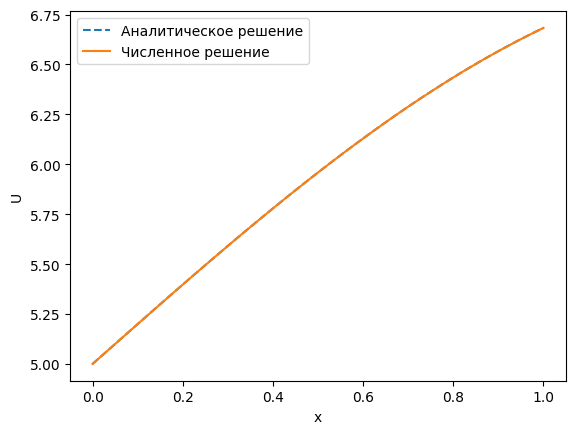

In [11]:
plt.plot(x_grid, U_exact, linestyle = '--', label = 'Аналитическое решение')
plt.plot(x_grid, U[N - 1], label = 'Численное решение')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()

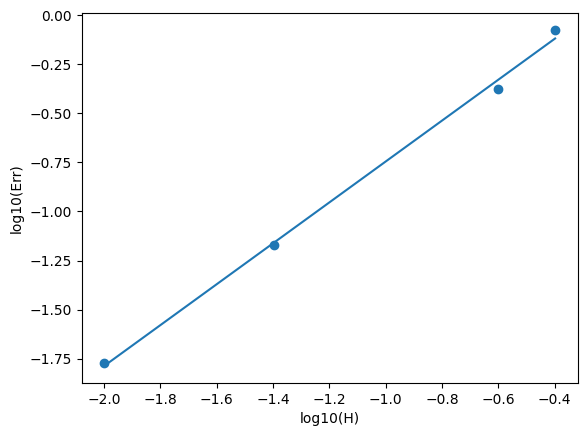

In [13]:
K = 4
TAU_arr = np.array([0.4, 0.25, 0.04, 0.01]) 
error_arr = np.zeros(K)

def aver(data):
  return np.sum(data) / np.size(data)
def MNK(x, y):
  k = (aver(x * y) - aver(x) * aver(y)) / (aver(x**2) - aver(x)**2)
  b = aver(y) - k * aver(x)
  return k, b

for i in range(K):
    TAU = TAU_arr[i]
    H = TAU**0.5
    M = int(L / H)
    N = int(T / TAU)
    x_grid = np.linspace(0, L, M + 1)
    U_num = heat_equation_crank_nicholson_solver(D, L, H, T, TAU)
    U_exact = exact_sol(x_grid, T)
    error_arr[i] = np.max(np.abs(U_exact - U_num[N - 1]))
    
k_1, b_1 = MNK(np.log10(TAU_arr), np.log10(error_arr))
plt.plot(np.log10(TAU_arr), k_1 * np.log10(TAU_arr) + b_1)
plt.scatter(np.log10(TAU_arr), np.log10(error_arr))
plt.xlabel('log10(H)')
plt.ylabel('log10(Err)')
plt.show()

In [14]:
print('Порядок аппроксимации по времени {}'.format(k_1))

Порядок аппроксимации по времени 1.0414654477100043


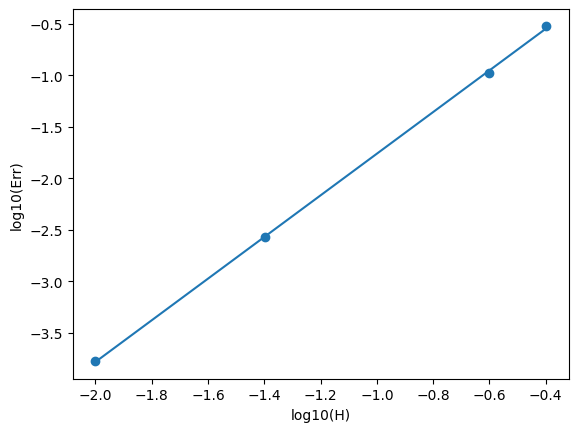

In [15]:
K = 4
H_arr = np.array([0.4, 0.25, 0.04, 0.01]) 
error_arr = np.zeros(K)

def aver(data):
  return np.sum(data) / np.size(data)
def MNK(x, y):
  k = (aver(x * y) - aver(x) * aver(y)) / (aver(x**2) - aver(x)**2)
  b = aver(y) - k * aver(x)
  return k, b

for i in range(K):
    H = H_arr[i]
    TAU = H**2
    M = int(L / H)
    N = int(T / TAU)
    x_grid = np.linspace(0, L, M + 1)
    U_num = heat_equation_crank_nicholson_solver(D, L, H, T, TAU)
    U_exact = exact_sol(x_grid, T)
    error_arr[i] = np.max(np.abs(U_exact - U_num[N - 1]))
    
k_2, b_2 = MNK(np.log10(H_arr), np.log10(error_arr))
plt.plot(np.log10(H_arr), k_2 * np.log10(H_arr) + b_2)
plt.scatter(np.log10(H_arr), np.log10(error_arr))
plt.xlabel('log10(H)')
plt.ylabel('log10(Err)')
plt.show()

In [16]:
print('Порядок аппроксимации по пространству {}'.format(k_2))

Порядок аппроксимации по пространству 2.0218869256007665
